In [1]:
!pip install rdkit xgboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 42.2 MB/s eta 0:00:00:00:0100:01


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Training libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score


# RDKit for chemical informatics
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem import rdFingerprintGenerator

In [3]:
# load the dataset
ki_data = pd.read_csv('/kaggle/input/ki-bind-dataset/Ki_bind.tsv', sep='\t') #('data/Ki_bind.tsv', sep='\t')

ki_data.head()

,drug_id,target_id,smiles,target_seq,origin_affinity,affinity
0,1,P04183,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MSCINLPTVLPGSPSKTRGQIQVILGPMFSGKSTELMRRVRRFQIA...,200,6.698970
1,1,P11413,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MAEQVALSRTQVCGILREELFQGDAFHQSDTHIFIIMGASGDLAKK...,1.54e+4,4.812479
2,1,P23919,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MAARRGALIVLEGVDRAGKSTQSRKLVEALCAAGHRAELLRFPERS...,180000,3.744727
3,1,P25099,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MPPYISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,>10000,4.999957
4,1,P30543,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MGSSVYITVELAIAVLAILGNVLVCWAVWINSNLQNVTNFFVVSLA...,>10000,4.999957


In [4]:
# inspect columns
ki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380365 entries, 0 to 380364
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   drug_id          380365 non-null  int64  
 1   target_id        380365 non-null  object 
 2   smiles           380365 non-null  object 
 3   target_seq       380365 non-null  object 
 4   origin_affinity  380365 non-null  object 
 5   affinity         380365 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 17.4+ MB


In [5]:
len(ki_data)

380365

In [6]:
ki_data.describe()

,drug_id,affinity
count,3.803650e+05,380365.000000
mean,3.601509e+07,6.822692
std,2.257446e+07,1.626958
min,1.000000e+00,-5.000000
25%,4.322240e+05,5.700275
50%,5.013560e+07,6.892790
75%,5.031928e+07,8.000000
max,5.054575e+07,14.522879


In [7]:
# check for any null/missing values
ki_data.isnull().sum()

drug_id            0
target_id          0
smiles             0
target_seq         0
origin_affinity    0
affinity           0
dtype: int64

In [8]:
## Exploratory Data Analysis (EDA)
# check for unique smile and protein_target

uniq_smiles = ki_data.smiles.unique()
uniq_targets = ki_data.target_seq.unique()

print(f"Unique SMILES: {len(uniq_smiles)}")
print(f"Unique Protein Targets: {len(uniq_targets)}")

Unique SMILES: 199949
Unique Protein Targets: 2716


In [9]:
# check for unique smile-target pairs
ki_copy = ki_data.copy()
unique_pairs = ki_copy[['smiles', 'target_seq']].drop_duplicates().shape[0]
print(f"Unique SMILES-Target pairs: {unique_pairs}")

Unique SMILES-Target pairs: 379743


In [10]:
ki_clean = ki_copy.drop_duplicates(subset=['smiles', 'target_seq'])
len(ki_clean)

379743

In [11]:
ki_copy['origin_affinity'].value_counts()

origin_affinity
>10000     16316
>1000       5571
>100000     3258
 1000       1900
>5000       1872
           ...  
 18.47         1
 7385          1
 269.17        1
 475.7         1
 82.83         1
Name: count, Length: 22006, dtype: int64

In [12]:
ki_copy['affinity'].describe()

count    380365.000000
mean          6.822692
std           1.626958
min          -5.000000
25%           5.700275
50%           6.892790
75%           8.000000
max          14.522879
Name: affinity, dtype: float64

In [13]:
ki_copy['origin_affinity'].describe()

count     380365
unique     22006
top       >10000
freq       16316
Name: origin_affinity, dtype: object

In [14]:
# Aggregate by counts to check if duplicates were true replicates
pair_counts = (ki_data.groupby(['smiles', 'target_seq']).size().reset_index(name='counts'))
pair_counts['counts']

### Getting values of 1 shows that most duplicates were indeed true replicates. hence data cleaning is on the right track

0         1
1         1
2         1
3         1
4         1
         ..
379738    1
379739    1
379740    1
379741    1
379742    1
Name: counts, Length: 379743, dtype: int64

In [15]:
ki_clean['affinity'].value_counts()

affinity
4.999957    16344
5.999566     5582
3.999996     3309
9.000000     2746
8.698970     2392
            ...  
7.605373        1
6.021865        1
7.672028        1
7.412401        1
7.081812        1
Name: count, Length: 19058, dtype: int64

In [16]:
# set biologically relevant affinity threshold
ki_clean = ki_clean[(ki_clean['affinity'] >= 3) & (ki_clean['affinity'] <= 12)] # keeps it in millimolar to picomolar range
ki_clean.reset_index(drop=True, inplace=True)
ki_clean['affinity'].describe()

count    375448.000000
mean          6.883230
std           1.501218
min           3.000000
25%           5.764472
50%           6.920819
75%           8.000000
max          12.000000
Name: affinity, dtype: float64

In [17]:
ki_clean.shape

(375448, 6)

In [18]:
# aggregate by unique smile-target pairs after cleaning
ki_clean = (ki_clean.groupby(['smiles', 'target_seq'], as_index=False).
            agg({'affinity': 'mean'})
            )

print(f"Shape after aggregation: {ki_clean.shape}")
print(f"Columns: {ki_clean.columns.tolist()}")
print(f"Unique protein sequences: {ki_clean['target_seq'].nunique()}")

ki_clean.shape

Shape after aggregation: (375448, 3)
Columns: ['smiles', 'target_seq', 'affinity']
Unique protein sequences: 2689


(375448, 3)

In [19]:
ki_clean.head()

,smiles,target_seq,affinity
0,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.744727
1,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,6.301030
2,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.251812
3,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.552842
4,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,5.154902


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of SMILES Lengths')

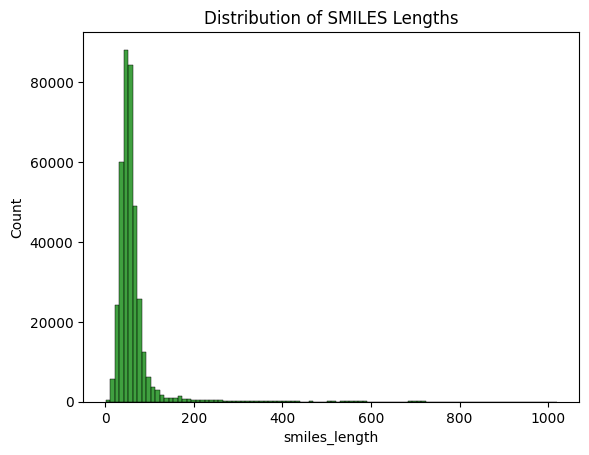

In [20]:
# plot smile length distribution
ki_clean['smiles_length'] = ki_clean['smiles'].apply(len)
sns.histplot(ki_clean['smiles_length'], bins=100, color='green')
plt.title('Distribution of SMILES Lengths')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


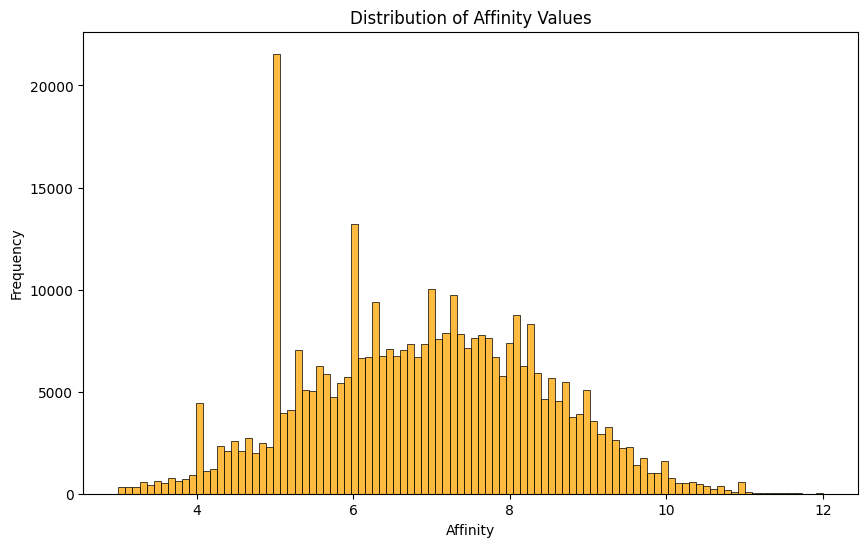

In [21]:
# plot affinity distribution 
plt.figure(figsize=(10, 6))
sns.histplot(ki_clean['affinity'], bins=100, color='orange')
plt.title('Distribution of Affinity Values')
plt.xlabel('Affinity')
plt.ylabel('Frequency')
plt.show()

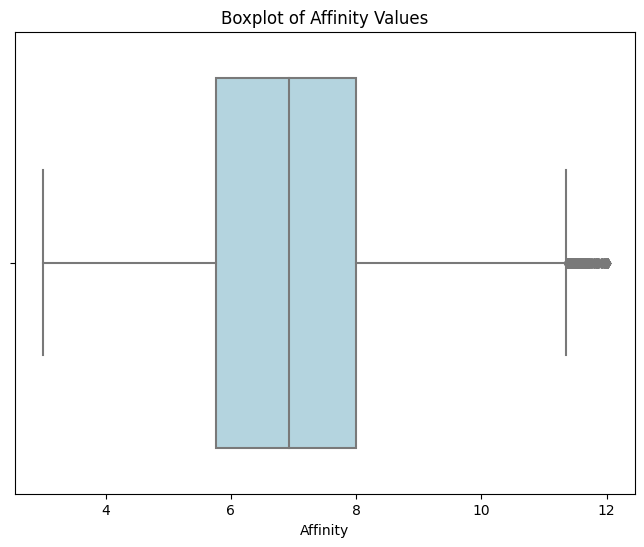

In [22]:
# boxplot ot check for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=ki_clean['affinity'], color='lightblue')
plt.title('Boxplot of Affinity Values')
plt.xlabel('Affinity')
plt.show()

In [23]:
# create 'activity' label based on affinity threshold (to convert project to classification task)
def classify_activity(pki):
    if pki >= 7:
        return 1 # means active
    elif pki <= 5:
        return 0 # means inactive/weak binder
    else:
        return np.nan # mark as intermediate or optional
    

# apply class labeling function
ki_clean['activity'] = ki_clean['affinity'].apply(classify_activity)
ki_clean.dropna(subset=['activity'], inplace=True)

In [24]:
ki_clean['activity'].value_counts()

activity
1.0    181140
0.0     49242
Name: count, dtype: int64

In [25]:
ki_clean['activity'].value_counts(normalize=True)

activity
1.0    0.786259
0.0    0.213741
Name: proportion, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

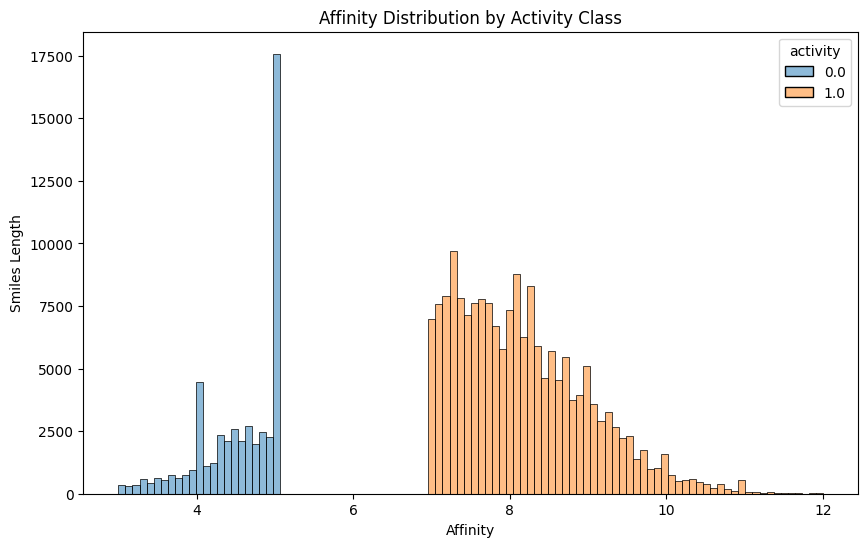

In [26]:
# plot smile affinity by activity
plt.figure(figsize=(10, 6))
sns.histplot(data=ki_clean, x='affinity', bins=100, hue='activity')
plt.title('Affinity Distribution by Activity Class')
plt.xlabel('Affinity')
plt.ylabel('Smiles Length')
plt.show()

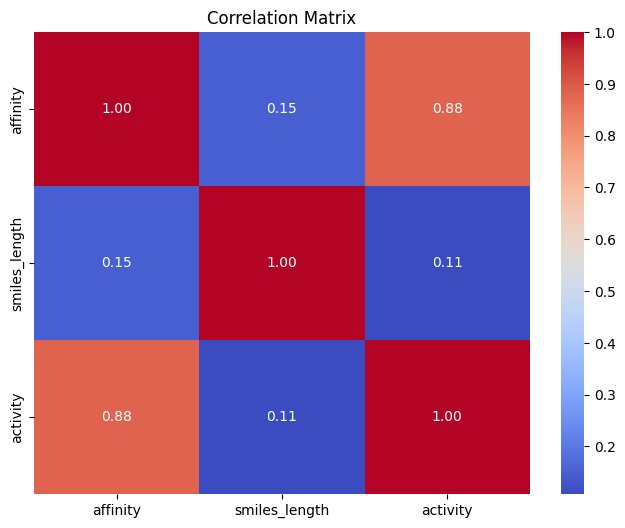

In [27]:
# plot correlation
num_cols = ['affinity', 'smiles_length', 'activity']
plt.figure(figsize=(8, 6))
sns.heatmap(ki_clean[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [28]:
# Encoding smiles and protein sequence columns
from tqdm import tqdm
from rdkit.DataStructs import ConvertToNumpyArray
from collections import Counter

def encode_smiles(smiles, radius=2, n_bits=1024):
    """
    convert a SMILES string to a Morgan fingerprint numpy array of length n_bits
    Returns np.nan on failure
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: # if conversion fails
            return np.nan
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius, fpSize=n_bits)
        fp = fp_gen.GetFingerprint(mol)
        # create an array sized to the fingerprint length
        arr = np.zeros((n_bits,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    except Exception as e:
        print(f"Error encoding smiles '{smiles}': {e}")
        return np.nan



AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
def encode_protein_sequence(sequence):
    """
    Convert a protein sequence into a simple amino acid composition vector
    Return np.nan on failure
    """
    if not isinstance(sequence, str):
        return np.nan
    seq = sequence.strip().upper()
    if len(seq) == 0:
        return np.nan
    counts = Counter(seq)
    total = len(seq)
    composition = np.array([counts.get(aa, 0) / total for aa in AMINO_ACIDS], dtype=float)
    
    return composition



# Apply encoding functions to the dataset
tqdm.pandas()
ki_clean['smiles_fp'] = ki_clean['smiles'].progress_apply(encode_smiles)
ki_clean['protein_comp'] = ki_clean['target_seq'].progress_apply(encode_protein_sequence)

  2%|▏         | 4241/230382 [00:01<01:33, 2430.39it/s][23:22:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
[23:22:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 28 29 30 31
  3%|▎         | 7810/230382 [00:03<01:42, 2174.42it/s][23:22:48] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
[23:22:48] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 29 30 31
  6%|▌         | 12909/230382 [00:06<01:46, 2034.88it/s][23:22:51] Explicit valence for atom # 6 N, 4, is greater than permitted
[23:22:51] Explicit valence for atom # 6 N, 4, is greater than permitted
 14%|█▍        | 31876/230382 [00:16<01:33, 2113.37it/s][23:23:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[23:23:02] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 19 20 21 22
[23:23:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
[23:23:02] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 18 19 20 21
 25%|██▍       | 56514/230382 

In [29]:
# QC
n_fail_smiles = ki_clean['smiles_fp'].isna().sum()
n_fail_protein = ki_clean['protein_comp'].isna().sum()

print(f"Number of failed SMILES encodings: {n_fail_smiles}")
print(f"Number of failed Protein sequence encodings: {n_fail_protein}")

# drop rows where either encoding failed
ki_clean = ki_clean.dropna(subset=['smiles_fp', 'protein_comp']).reset_index(drop=True)

Number of failed SMILES encodings: 160
Number of failed Protein sequence encodings: 0


In [30]:
ki_clean.head()

,smiles,target_seq,affinity,smiles_length,activity,smiles_fp,protein_comp
0,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.744727,87,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.04, 0.04108108108108108, 0.0518918918918918..."
1,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.251812,82,0.0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0.04, 0.04108108108108108, 0.0518918918918918..."
2,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.552842,86,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.04, 0.04108108108108108, 0.0518918918918918..."
3,Br.C(CN1CCc2ccccc2C1)Cc1nc2ccccc2s1,MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQI...,7.744727,35,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.060291060291060294, 0.016632016632016633, 0..."
4,Br.C(CN1CCc2ccccc2C1)Cc1nc2ccccc2s1,MASLSQLSSHLNYTCGAENSTGASQARPHAYYALSYCALILAIVFG...,7.102373,35,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.075, 0.04, 0.02, 0.03, 0.0425, 0.055, 0.02,..."


In [31]:
# convert columns of arrays into feature matrices
X_mol = np.stack(ki_clean['smiles_fp'].values)
X_prot = np.stack(ki_clean['protein_comp'].values)
X = np.concatenate([X_mol, X_prot], axis=1)
y = ki_clean['activity'].values

In [32]:
X.shape, y.shape

((230222, 1044), (230222,))

In [33]:
# Verify protein features are varying in the final feature matrix
print("=== Final Feature Matrix Verification ===")
print(f"Total features: {X.shape[1]} (1024 molecular + 20 protein)")
print(f"Molecular features: columns 0-1023")
print(f"Protein features: columns 1024-1043")

# Check variance in protein features
protein_features = X[:, 1024:]
print(f"\nProtein feature statistics:")
print(f"  Mean variance across protein features: {np.var(protein_features, axis=0).mean():.6f}")
print(f"  Min variance: {np.var(protein_features, axis=0).min():.6f}")
print(f"  Max variance: {np.var(protein_features, axis=0).max():.6f}")

# Check if protein features are all identical
if len(X) > 1:
    unique_protein_vectors = np.unique(protein_features, axis=0)
    print(f"\nUnique protein feature vectors: {len(unique_protein_vectors)}")
    if len(unique_protein_vectors) == 1:
        print("⚠️ CRITICAL: All protein features are identical!")
        print("Your model is NOT learning protein-specific information.")
    else:
        print(f"✓ Good: {len(unique_protein_vectors)} different protein feature patterns detected")

=== Final Feature Matrix Verification ===
Total features: 1044 (1024 molecular + 20 protein)
Molecular features: columns 0-1023
Protein features: columns 1024-1043

Protein feature statistics:
  Mean variance across protein features: 0.000268
  Min variance: 0.000068
  Max variance: 0.000500

Unique protein feature vectors: 2412
✓ Good: 2412 different protein feature patterns detected


### **Save datasets**

In [34]:
# save features and labels as numpy arrays
np.save('X_features.npy', X)
np.save('y_labels.npy', y)

# save raw + processed dataset
ki_clean.to_parquet("processed_dtabioactivty_data.parquet", index=False)

### **Baseline Model**

In [35]:
# load numpy files
X = np.load('/kaggle/input/numpy-files/X_features.npy', allow_pickle=True)
y = np.load('/kaggle/input/numpy-files/y_labels.npy', allow_pickle=True)

In [36]:
# splitting the data
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, 
                                                              test_size=0.2, 
                                                              random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, 
                                                  test_size=0.25, 
                                                  random_state=42)

In [37]:
print(f"Train sizes: {X_train.shape}, {y_train.shape}")
print(f"Test sizes: {X_test.shape}, {y_test.shape}")
print(f"Validation sizes: {X_val.shape}, {y_val.shape}")
print(f"Original datasizes: {X.shape}, {y.shape}")

Train sizes: (138132, 1044), (138132,)
Test sizes: (46045, 1044), (46045,)
Validation sizes: (46045, 1044), (46045,)
Original datasizes: (230222, 1044), (230222,)


### **Logistic Regression**

In [38]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)
print(f"Baseline logistic regression score: {round(score, 3)}")

Baseline logistic regression score: 0.84


In [39]:
# confusion matrix, f1 score, etc, etc
y_pred_labels = (y_pred >= 0.5).astype(int)

In [40]:
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.47      0.76      0.58      9870
         1.0       0.92      0.76      0.83     36175

    accuracy                           0.76     46045
   macro avg       0.69      0.76      0.71     46045
weighted avg       0.82      0.76      0.78     46045



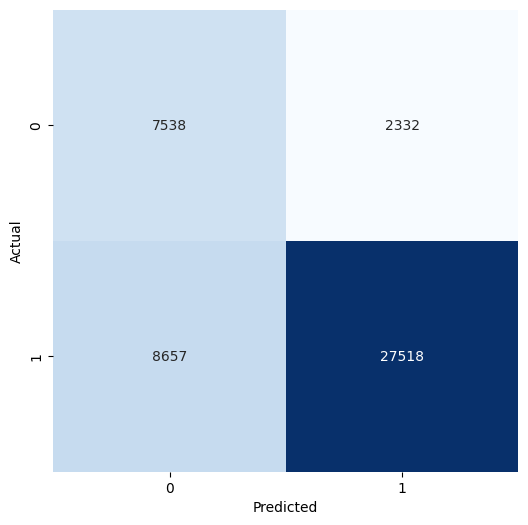

In [41]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [42]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC: {roc_auc:.3f}")

ROC-AUC: 0.840


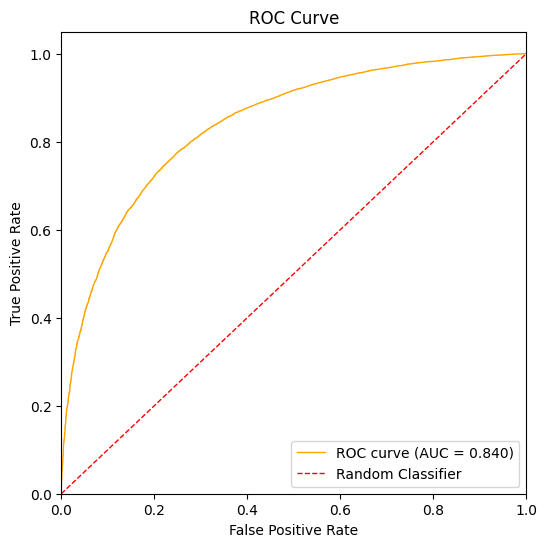

In [43]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', lw=1, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [44]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
avg_precision = average_precision_score(y_val, y_pred)

print(f"Average Precision (AP): {avg_precision:.3f}")

Average Precision (AP): 0.945


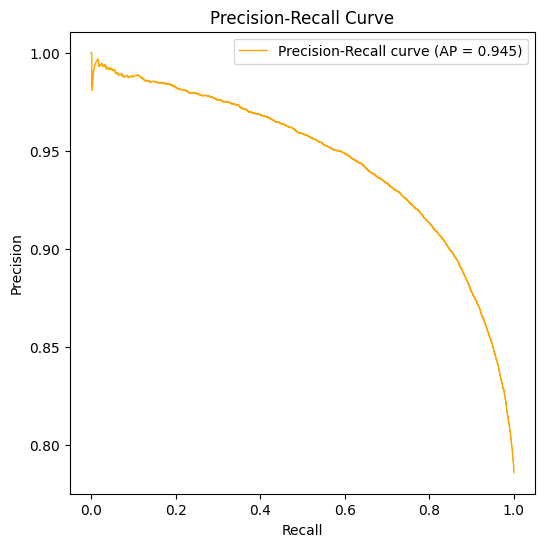

In [45]:
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='orange', lw=1, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [46]:
# hyperparameter tuning of logistic regression
def tune_parameters(model, params, X_train, y_train, cv=3, scoring='roc_auc'):
    """
    Utility function using GridSearchCV to tune model hyperparameters
    """
    grid = GridSearchCV(model, params, cv=cv, scoring=scoring, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_}")
    return grid.best_estimator_

In [47]:
logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']

}

lr_tuning = tune_parameters(LogisticRegression(max_iter=1000, random_state=42),
                            logistic_params, X_train, y_train, cv=3,
                           )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ....C=0.01, class_weight=balanced, solver=liblinear; total time=   7.5s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   9.9s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   9.8s
[CV] END .....C=0.1, class_weight=balanced, solver=liblinear; total time=   9.8s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time= 2.2min
[CV] END ............C=1, class_weight=balanced, solver=saga; total time= 9.1min
[CV] END ....C=0.01, class_weight=balanced, solver=liblinear; total time=   6.4s
[CV] END .........C=0.01, class_weight=balanced, solver=saga; total time=  39.7s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time= 2.1min
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=  22.4s
[CV] END ......C=10, class_weight=balanced, solver=liblinear; total time=  23.9s
[CV] END ......C=10, class_weight=balanced, solve

In [48]:
# final logistic regression model
best_lr = LogisticRegression(max_iter=1000, solver='liblinear', C=10, class_weight='balanced')
best_lr.fit(X_full_train, y_full_train)
y_pred = best_lr.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)
print(f"Final score of tuned LR model: {round(score, 3)}")

Final score of tuned LR model: 0.841


In [49]:
y_pred_labels = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.47      0.77      0.58      9863
         1.0       0.92      0.76      0.83     36182

    accuracy                           0.76     46045
   macro avg       0.69      0.76      0.71     46045
weighted avg       0.82      0.76      0.78     46045



In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

print(f"Average Precision (AP): {avg_precision:.3f}")

Average Precision (AP): 0.946


### **RandomForestClassifier**

In [51]:
rfc = RandomForestClassifier(n_estimators=100, 
                             random_state=42, 
                             n_jobs=-1, 
                             class_weight='balanced')

rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict_proba(X_val)[:, 1]

score = roc_auc_score(y_val, y_pred_rfc)
print(f"Initial RFC score: {score:.3f}")

Initial RFC score: 0.987


In [52]:
y_pred_labels = (y_pred_rfc >= 0.5).astype(int)
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88      9870
         1.0       0.95      0.99      0.97     36175

    accuracy                           0.95     46045
   macro avg       0.95      0.90      0.92     46045
weighted avg       0.95      0.95      0.95     46045



In [53]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_rfc)
avg_precision = average_precision_score(y_val, y_pred_rfc)

print(f"Average Precision (AP): {avg_precision:.3f}")

Average Precision (AP): 0.996


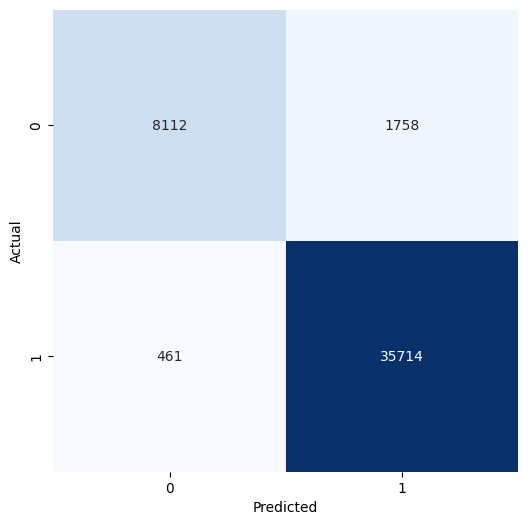

In [54]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

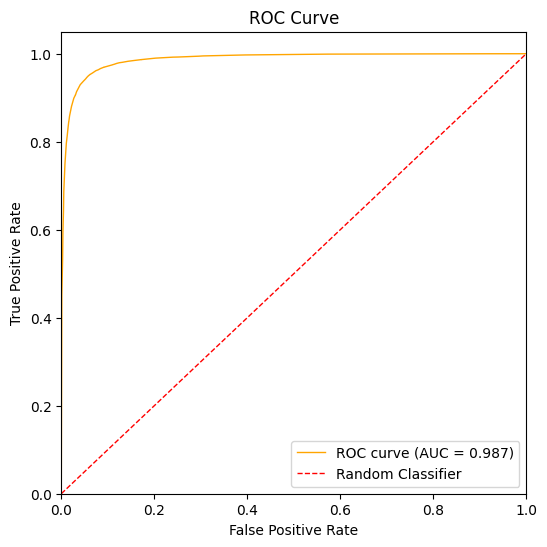

In [55]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_rfc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', lw=1, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

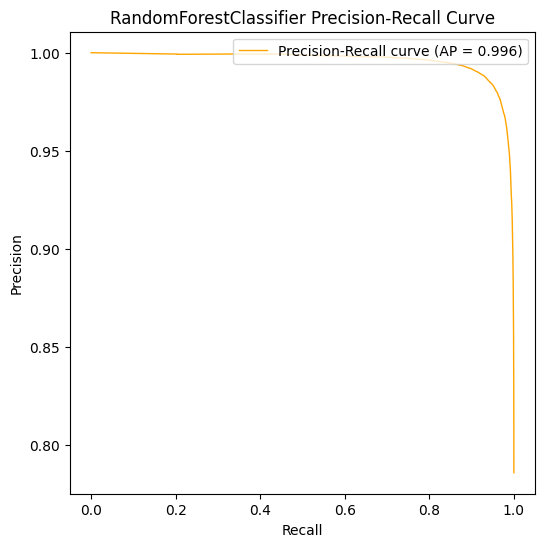

In [56]:
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='orange', lw=1, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForestClassifier Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [57]:
## minimal hyperparameter tuning for Random Forest Classifier
rfc_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 3],
    "class_weight": ["balanced"]
}

In [58]:
best_rfc = tune_parameters(RandomForestClassifier(random_state=42, n_jobs=-1), 
                           rfc_params, 
                           X_train, 
                           y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.981622355910419


In [59]:
# train final rfc
rfc_f = RandomForestClassifier(n_estimators=200,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              class_weight='balanced',
                              random_state=42,
                              n_jobs=-1)

rfc_f.fit(X_full_train, y_full_train)

y_pred_probs_final = rfc_f.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred_probs_final)

print(f"RFc final score on test_data: {score:.3f}")

[CV] END ....C=0.01, class_weight=balanced, solver=liblinear; total time=   7.4s
[CV] END .........C=0.01, class_weight=balanced, solver=saga; total time=  41.1s
[CV] END .......C=1, class_weight=balanced, solver=liblinear; total time=  17.4s
[CV] END .......C=1, class_weight=balanced, solver=liblinear; total time=  19.8s
[CV] END .......C=1, class_weight=balanced, solver=liblinear; total time=  21.2s
[CV] END ............C=1, class_weight=balanced, solver=saga; total time= 8.9min
[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=13.4min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  29.7s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  59.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.9min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf

Average Precision (AP): 0.997


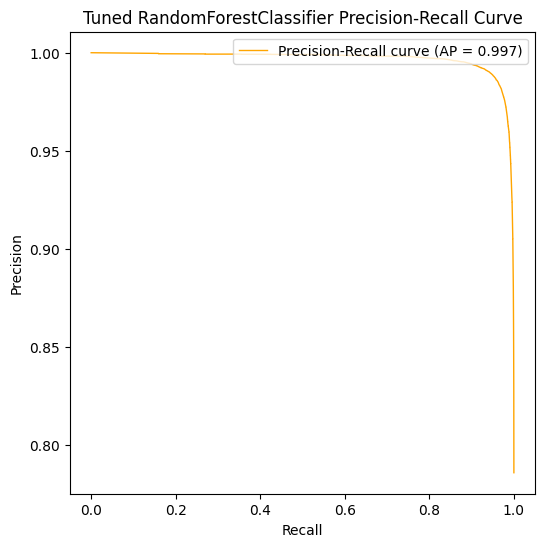

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs_final)
avg_precision = average_precision_score(y_test, y_pred_probs_final)

print(f"Average Precision (AP): {avg_precision:.3f}")


plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='orange', lw=1, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Tuned RandomForestClassifier Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

Average molecular feature importance: 0.000701856639974087
Average protein feature importance: 0.014064940033326747


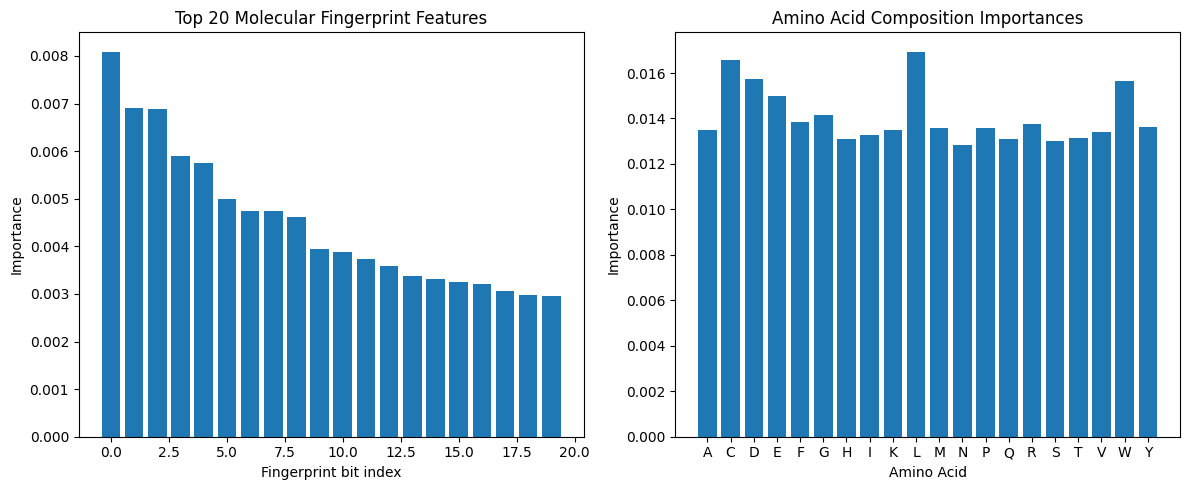

In [61]:
# Get feature importances
importances = rfc_f.feature_importances_

# Split them into molecular and protein feature groups
mol_importances = importances[:1024]
prot_importances = importances[1024:]

print("Average molecular feature importance:", mol_importances.mean())
print("Average protein feature importance:", prot_importances.mean())

# Sort and visualize the top fingerprint bits and amino acids
top_mol_idx = np.argsort(mol_importances)[-20:][::-1]
top_prot_idx = np.argsort(prot_importances)[-10:][::-1]

plt.figure(figsize=(12, 5))

# Plot top 20 molecular fingerprint features
plt.subplot(1, 2, 1)
plt.bar(range(20), mol_importances[top_mol_idx])
plt.title("Top 20 Molecular Fingerprint Features")
plt.xlabel("Fingerprint bit index")
plt.ylabel("Importance")

# Plot amino acid composition importances
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
plt.subplot(1, 2, 2)
plt.bar(amino_acids, prot_importances)
plt.title("Amino Acid Composition Importances")
plt.xlabel("Amino Acid")
plt.ylabel("Importance")

plt.tight_layout()
plt.show()

# assessment: individual amino acids play a stronger role in determining active/inactive drug molecules

### **Save the Random Forest Classifier**

In [62]:
import joblib # use joblib for larger models
from joblib import dump

dump(rfc_f, 'bioactivity_prediction_rf_model.joblib')

['bioactivity_prediction_rf_model.joblib']

In [63]:
# testing with pickle
import pickle

with open('bioactivity_prediction_rf_model.pkl', 'wb') as file:
    pickle.dump(rfc_f, file)

### **XGBoost Classifier**

In [64]:
# using xgboost classifier instead of normal xgb

xgb_clf = XGBClassifier(
    n_estimators=100,
    tree_method = 'hist',
    scale_pos_weight = ((y_train==0).sum()/(y_train==1).sum()),
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=True,
)

# Step 2: Retrieve the evaluation results
evals_result = xgb_clf.evals_result()

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.75487	validation_1-auc:0.74330
[1]	validation_0-auc:0.79229	validation_1-auc:0.77862
[2]	validation_0-auc:0.81997	validation_1-auc:0.80803
[3]	validation_0-auc:0.83474	validation_1-auc:0.82327
[4]	validation_0-auc:0.83992	validation_1-auc:0.82852
[5]	validation_0-auc:0.84892	validation_1-auc:0.83864
[6]	validation_0-auc:0.85801	validation_1-auc:0.84703
[7]	validation_0-auc:0.86404	validation_1-auc:0.85305
[8]	validation_0-auc:0.87103	validation_1-auc:0.86018
[9]	validation_0-auc:0.87583	validation_1-auc:0.86469
[10]	validation_0-auc:0.88116	validation_1-auc:0.87002
[11]	validation_0-auc:0.88501	validation_1-auc:0.87342
[12]	validation_0-auc:0.88897	validation_1-auc:0.87717
[13]	validation_0-auc:0.89201	validation_1-auc:0.88029
[14]	validation_0-auc:0.89489	validation_1-auc:0.88298
[15]	validation_0-auc:0.89870	validation_1-auc:0.88681
[16]	validation_0-auc:0.90079	validation_1-auc:0.88889
[17]	validation_0-auc:0.90384	validation_1-auc:0.89162
[18]	validation_0-au

In [65]:
y_pred_prob_xgb = xgb_clf.predict_proba(X_val)[:, 1]
roc_score = roc_auc_score(y_val, y_pred_prob_xgb)
print(f"ROC-AUC score of XGBc: {roc_score:.3f}")

ROC-AUC score of XGBc: 0.954


In [66]:
# Precision-Recall AUC (often more informative for imbalanced data)
pr_score = average_precision_score(y_val, y_pred_prob_xgb)

# Binary predictions for classification metrics
y_pred_xgb = xgb_clf.predict(X_val)

print(f"PR-AUC: {pr_score:.3f}")
print(classification_report(y_val, y_pred_xgb))

PR-AUC: 0.986
              precision    recall  f1-score   support

         0.0       0.69      0.88      0.77      9870
         1.0       0.97      0.89      0.93     36175

    accuracy                           0.89     46045
   macro avg       0.83      0.89      0.85     46045
weighted avg       0.91      0.89      0.89     46045



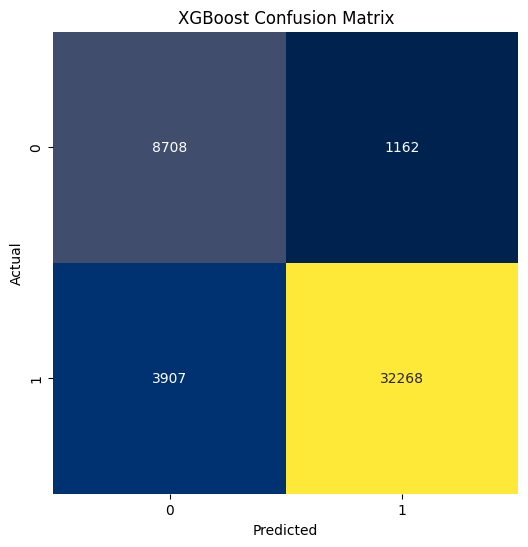

In [67]:
# confusion matrix report of XGB
cm = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='cividis', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

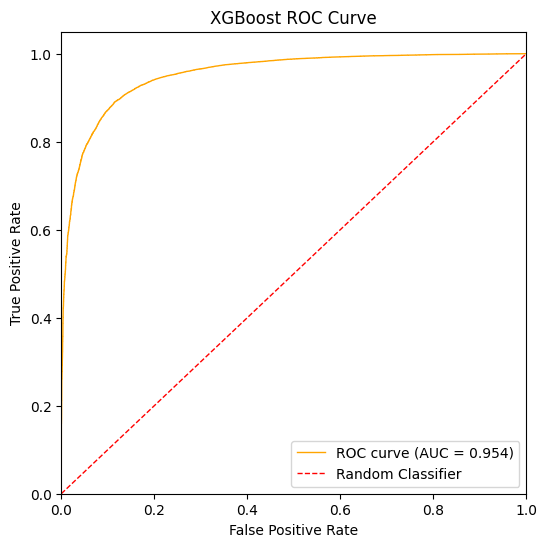

In [68]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', lw=1, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [69]:
# use RandomizedSearchCV for faster compute (I'm running out of patience here)
from sklearn.model_selection import RandomizedSearchCV


def tune_params(model, params, X_train, y_train, n_iter=20, cv=3, scoring='roc_auc', random_state=42):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        random_state=random_state
    )
    search.fit(X_train, y_train)
    print("\nBest parameters found:")
    print(search.best_params_)
    print(f"Best CV ROC-AUC score: {search.best_score_:.3f}")

    return search.best_estimator_

In [70]:
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "min_child_weight": [1, 5, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
    "scale_pos_weight": [(y_train==0).sum() / (y_train==1).sum()]
}

best_xgb = tune_params(XGBClassifier(use_label_encoder=False, eval_metric='auc', n_jobs=-1, random_state=42),
                           xgb_params, 
                           X_train, 
                           y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.9min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  59.8s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.9min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.0min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  32.5s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.0min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_sa

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .........C=0.01, class_weight=balanced, solver=saga; total time=  42.9s
[CV] END ..........C=0.1, class_weight=balanced, solver=saga; total time= 2.1min
[CV] END ............C=1, class_weight=balanced, solver=saga; total time= 9.0min
[CV] END ...........C=10, class_weight=balanced, solver=saga; total time=12.9min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  30.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  34.2s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  33.4s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  59.7s
[CV] END class_weight=balanced, max_depth=10, min_samples_l

In [71]:
## train final XGBoost with best params
xgb_final_params = {
    'subsample': 1.0,  
    'n_estimators': 300, 
    'min_child_weight': 5, 
    'max_depth': 6, 
    'learning_rate': 0.3, 
    'colsample_bytree': 0.7}

xgb_final = XGBClassifier(
    **xgb_final_params,
    tree_method = 'hist',
    scale_pos_weight = ((y_train==0).sum()/(y_train==1).sum()),
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
)

xgb_final.fit(
    X_train, y_train,
    eval_set=[(X_full_train, y_full_train), (X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True,
)

# Step 2: Retrieve the evaluation results
evals_result_final = xgb_clf.evals_result()

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73903	validation_1-auc:0.73457
[1]	validation_0-auc:0.77978	validation_1-auc:0.77298
[2]	validation_0-auc:0.80098	validation_1-auc:0.79362
[3]	validation_0-auc:0.82109	validation_1-auc:0.81282
[4]	validation_0-auc:0.83295	validation_1-auc:0.82480
[5]	validation_0-auc:0.83938	validation_1-auc:0.83134
[6]	validation_0-auc:0.84874	validation_1-auc:0.84074
[7]	validation_0-auc:0.85477	validation_1-auc:0.84697
[8]	validation_0-auc:0.86227	validation_1-auc:0.85455
[9]	validation_0-auc:0.86912	validation_1-auc:0.86144
[10]	validation_0-auc:0.87331	validation_1-auc:0.86552
[11]	validation_0-auc:0.87768	validation_1-auc:0.86979
[12]	validation_0-auc:0.88060	validation_1-auc:0.87266
[13]	validation_0-auc:0.88397	validation_1-auc:0.87550
[14]	validation_0-auc:0.88665	validation_1-auc:0.87802
[15]	validation_0-auc:0.88965	validation_1-auc:0.88107
[16]	validation_0-auc:0.89405	validation_1-auc:0.88525
[17]	validation_0-auc:0.89561	validation_1-auc:0.88663
[18]	validation_0-au

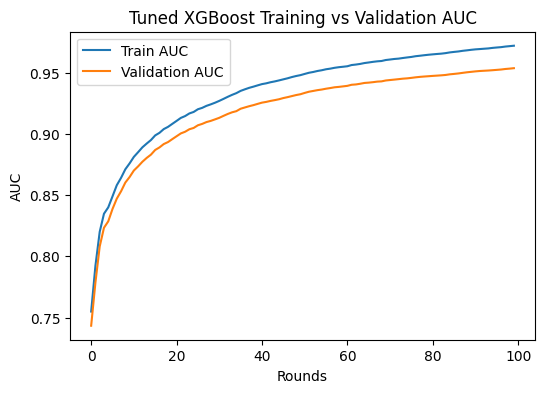

In [72]:
train_auc = evals_result['validation_0']['auc']
val_auc = evals_result['validation_1']['auc']

plt.figure(figsize=(6,4))
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Rounds')
plt.ylabel('AUC')
plt.title('Tuned XGBoost Training vs Validation AUC')
plt.legend()
plt.show()

Final XGBClassifier ROC-AUC score: 0.973
Final XGBClassifier PR-AUC score: 0.992



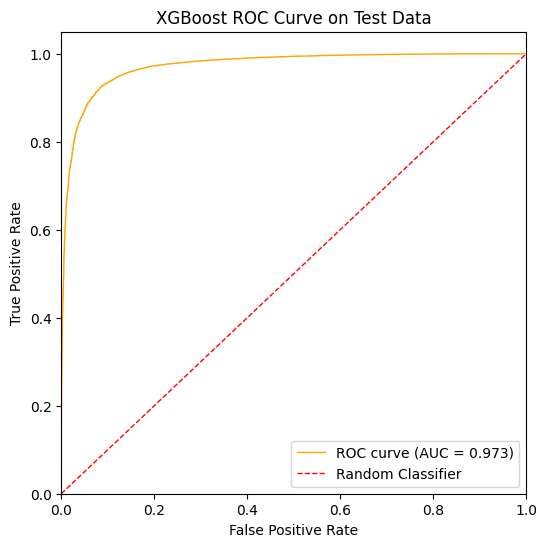

In [73]:
# test
xgb_y_pred_final = xgb_final.predict_proba(X_test)[:, 1]
final_test_score = roc_auc_score(y_test, xgb_y_pred_final)
pr_score_final = average_precision_score(y_test, xgb_y_pred_final)

fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred_final)
roc_auc_final = auc(fpr, tpr)

print(f"Final XGBClassifier ROC-AUC score: {final_test_score:.3f}")
print(f"Final XGBClassifier PR-AUC score: {pr_score_final:.3f}")
print()

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', lw=1, label=f'ROC curve (AUC = {roc_auc_final:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

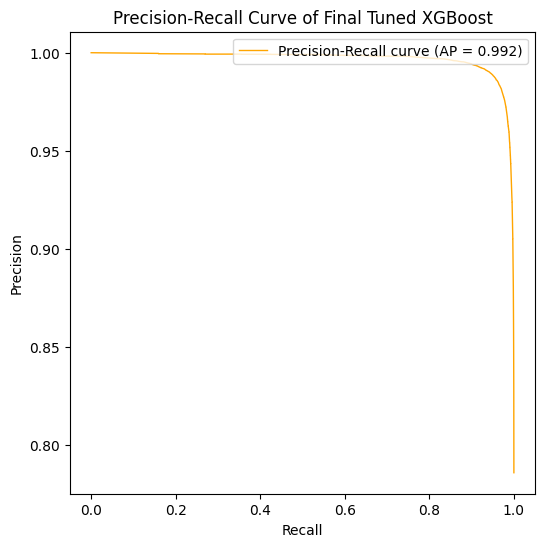

In [74]:
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='orange', lw=1, label=f'Precision-Recall curve (AP = {pr_score_final:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Final Tuned XGBoost')
plt.legend(loc='upper right')
plt.show()

### **Save tuned XGBoost model as backup**

In [75]:
xgb_final.save_model('bioactivity_prediction_xgb_model.json')

In [76]:
dump(xgb_final, 'bioactivity_prediction_xgb_model.joblib')

['bioactivity_prediction_xgb_model.joblib']